# Crop Production analysis and modelling using LSTM

Import all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing  import StandardScaler
import seaborn as sns
%matplotlib inline
#from datetime import datetime

In [2]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

In [3]:
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.models import Sequential

In [4]:
data = pd.read_csv("C:/Users/Sharoz/Downloads/UOB Subjects/Semester2/GroupProject/Dataset_Crop_final.csv")

In [5]:
data.head()

,Element,Item,Year,Production Unit,Production Value,Area Harvested Unit,Area Harvested Value,Year.1,Import Value Unit,Import Value,Import Quantity Unit,Import Quantity Value,Export Quantity Unit,Export Quantity Value,Export Value Unit,Export value,Population,Temperature Unit,Temperature,Rainfall
0,Production,Apples,1970,tonnes,596015.0,ha,33000.0,1970,1000 US$,73231.0,tonnes,258500.0,tonnes,10923.0,1000 US$,2124.0,55663250,°C,8.31,1120.5
1,Production,Apples,1971,tonnes,530276.0,ha,33000.0,1971,1000 US$,81325.0,tonnes,264783.0,tonnes,11177.0,1000 US$,2498.0,55896223,°C,8.73,935.3
2,Production,Apples,1972,tonnes,375227.0,ha,31000.0,1972,1000 US$,98166.0,tonnes,277080.0,tonnes,16467.0,1000 US$,4574.0,56086065,°C,8.10,986.4
3,Production,Apples,1973,tonnes,490041.0,ha,31000.0,1973,1000 US$,127635.0,tonnes,331874.0,tonnes,12404.0,1000 US$,4772.0,56194527,°C,8.43,928.8
4,Production,Apples,1974,tonnes,396800.0,ha,32000.0,1974,1000 US$,123951.0,tonnes,312089.0,tonnes,14900.0,1000 US$,4344.0,56229974,°C,8.38,1180.7


# Filtering the data and considering only wheat (Major crop of UK) for further processing

In [6]:
array = ['Wheat']
df_new = data.loc[data['Item'].isin(array)]
df_new.head()

,Element,Item,Year,Production Unit,Production Value,Area Harvested Unit,Area Harvested Value,Year.1,Import Value Unit,Import Value,Import Quantity Unit,Import Quantity Value,Export Quantity Unit,Export Quantity Value,Export Value Unit,Export value,Population,Temperature Unit,Temperature,Rainfall
4252,Production,Wheat,1970,tonnes,4237460.0,ha,1010392.0,1970,1000 US$,345502.0,tonnes,4983614.0,tonnes,165.0,1000 US$,484.0,55663250,°C,8.31,1120.5
4253,Production,Wheat,1971,tonnes,4816560.0,ha,1097425.0,1971,1000 US$,335894.0,tonnes,4605931.0,tonnes,114.0,1000 US$,719.0,55896223,°C,8.73,935.3
4254,Production,Wheat,1972,tonnes,4781540.0,ha,1127412.0,1972,1000 US$,310143.0,tonnes,4191115.0,tonnes,171.0,1000 US$,1113.0,56086065,°C,8.10,986.4
4255,Production,Wheat,1973,tonnes,5004535.0,ha,1146412.0,1973,1000 US$,414550.0,tonnes,3778939.0,tonnes,109.0,1000 US$,1463.0,56194527,°C,8.43,928.8
4256,Production,Wheat,1974,tonnes,6131587.0,ha,1233432.0,1974,1000 US$,579083.0,tonnes,2856339.0,tonnes,111.0,1000 US$,427.0,56229974,°C,8.38,1180.7


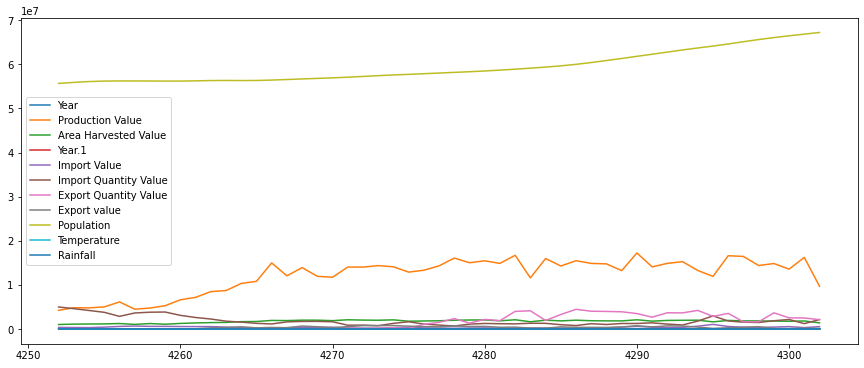

In [7]:
#Plotting the graph to check for seasonality
df_new.plot(figsize=(15,6))
#Dropping all the unnecessary columns
df_production = df_new.drop(['Element','Item','Production Unit','Import Quantity Unit','Export Value Unit ','Area Harvested Unit','Year.1','Import Value Unit','Export Quantity Unit','Temperature Unit','Population','Import Value','Export value','Export Quantity Value'],axis=1)

# Resampling of yearly data into monthly to get the sufficient data points

In [8]:
datetime_series = pd.to_datetime(df_production['Year'].astype(str))
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df_production.set_index(datetime_index)
df.drop('Year',axis=1,inplace=True)
df

,Production Value,Area Harvested Value,Import Quantity Value,Temperature,Rainfall
1970-01-01,4237460.0,1010392.0,4983614.0,8.31,1120.5
1971-01-01,4816560.0,1097425.0,4605931.0,8.73,935.3
1972-01-01,4781540.0,1127412.0,4191115.0,8.10,986.4
1973-01-01,5004535.0,1146412.0,3778939.0,8.43,928.8
1974-01-01,6131587.0,1233432.0,2856339.0,8.38,1180.7
1975-01-01,4488000.0,1035432.0,3626012.0,8.77,921.4
1976-01-01,4740000.0,1231000.0,3802333.0,8.74,974.1
1977-01-01,5274163.0,1076230.0,3841242.0,8.27,1103.5
1978-01-01,6610000.0,1258417.0,3086284.0,8.23,1062.2
1979-01-01,7168000.0,1370760.0,2600763.0,7.59,1171.5


In [9]:
df_monthly = df.resample('M').ffill()
df_monthly

,Production Value,Area Harvested Value,Import Quantity Value,Temperature,Rainfall
1970-01-31,4237460.0,1010392.0,4983614.0,8.31,1120.5
1970-02-28,4237460.0,1010392.0,4983614.0,8.31,1120.5
1970-03-31,4237460.0,1010392.0,4983614.0,8.31,1120.5
1970-04-30,4237460.0,1010392.0,4983614.0,8.31,1120.5
1970-05-31,4237460.0,1010392.0,4983614.0,8.31,1120.5
...,...,...,...,...,...
2019-09-30,16225000.0,1816000.0,1210184.0,9.39,1232.2
2019-10-31,16225000.0,1816000.0,1210184.0,9.39,1232.2
2019-11-30,16225000.0,1816000.0,1210184.0,9.39,1232.2
2019-12-31,16225000.0,1816000.0,1210184.0,9.39,1232.2


In [10]:
train_df = df_monthly.sort_index(ascending=True) #sorting the data based on year

# Add a dummy column to our record called “Predictions,” which will help later when it need to reverse the scaling of our data.

In [11]:
# List of considered Features
FEATURES = ['Production Value', 'Area Harvested Value','Import Quantity Value', 'Temperature','Rainfall' ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create a dataset with features and then filter the data using the FEATURES list.
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# To prepare the data for scaling, we create a prediction column and set dummy values.
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Production Value']

# Print the dataframe's tail.
data_filtered_ext.tail()

FEATURE LIST
['Production Value', 'Area Harvested Value', 'Import Quantity Value', 'Temperature', 'Rainfall']


,Production Value,Area Harvested Value,Import Quantity Value,Temperature,Rainfall,Prediction
2019-09-30,16225000.0,1816000.0,1210184.0,9.39,1232.2,16225000.0
2019-10-31,16225000.0,1816000.0,1210184.0,9.39,1232.2,16225000.0
2019-11-30,16225000.0,1816000.0,1210184.0,9.39,1232.2,16225000.0
2019-12-31,16225000.0,1816000.0,1210184.0,9.39,1232.2,16225000.0
2020-01-31,9658000.0,1387000.0,2133002.0,9.62,1333.8,9658000.0


In [12]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Production Value'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(601, 5)


# Transforming the Data

In [13]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 75

# Prediction Index
index_Close = data.columns.get_loc("Production Value")

# Split the training data into test and train data sets
# As a first step, we get the number of rows to train the model on 90% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN requires data in the [samples, time steps, features] format.
# We'll make N samples, sequence length time steps per sample, and 6 features in this example.
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Check that the prediction value and the input are the same.
# The first prediction value should be equal to the second input sample's last close price.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(466, 75, 5) (466,)
(60, 75, 5) (60,)
0.03868790018099877
0.03868790018099877


# Train the Multivariate Prediction Model

In [14]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

375 75 5


# Selecting hyperparameters as per the stability of loss curve and plotting the same

In [15]:
epochs = 50
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
15/15 [==============================] - 19s 951ms/step - loss: 0.1076 - val_loss: 0.0370
Epoch 2/50
15/15 [==============================] - 13s 866ms/step - loss: 0.0142 - val_loss: 0.0199
Epoch 3/50
15/15 [==============================] - 13s 855ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 4/50
15/15 [==============================] - 13s 855ms/step - loss: 0.0074 - val_loss: 0.0090
Epoch 5/50
15/15 [==============================] - 13s 859ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 6/50
15/15 [==============================] - 13s 875ms/step - loss: 0.0062 - val_loss: 0.0086
Epoch 7/50
15/15 [==============================] - 13s 853ms/step - loss: 0.0061 - val_loss: 0.0073
Epoch 8/50
15/15 [==============================] - 13s 856ms/step - loss: 0.0056 - val_loss: 0.0072
Epoch 9/50
15/15 [==============================] - 13s 862ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 10/50
15/15 [==============================] - 12s 829ms/step - loss: 0.0048 - val_lo

# LOSS CURVE

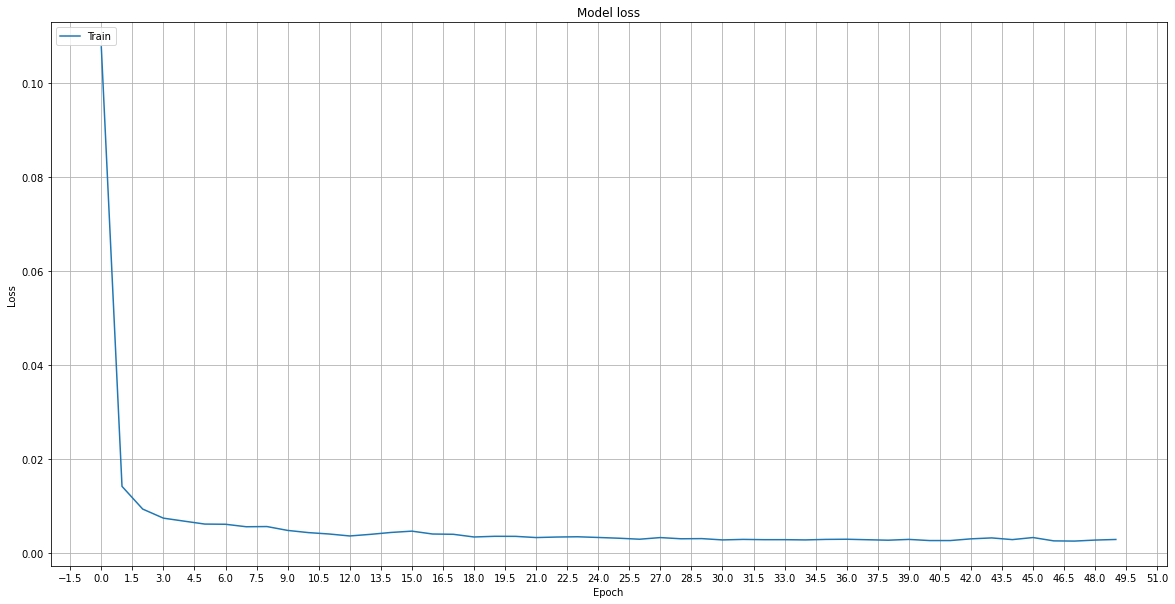

In [16]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [17]:
y_test_dummies = pd.get_dummies(y_test).values
print('Shape of Label tensor: ', y_test_dummies.shape)

Shape of Label tensor:  (60, 6)


# Performance Metric - MAPE(Mean Absolute Percentage Error)

In [18]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')


Mean Absolute Percentage Error (MAPE): 3.93 %


0.039334271593540984


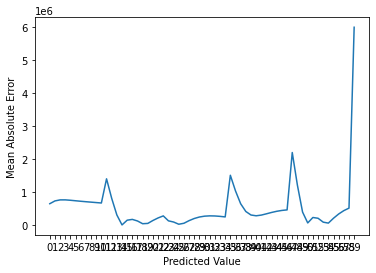

In [19]:
from matplotlib import pyplot
errors = np.abs(np.subtract(y_test_unscaled, y_pred))
MAPE = np.mean((errors/y_test_unscaled)) * 100
print(np.mean((errors/y_test_unscaled)))
pyplot.plot(errors)
pyplot.xticks(ticks=[i for i in range(len(errors))])
pyplot.xlabel('Predicted Value')
pyplot.ylabel('Mean Absolute Error')
pyplot.show()

In [20]:
# Add the date column
data_filtered_sub = data_filtered.copy()

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Production Value"], True)

# Line Plot of Actual Value Vs Predicted Value

C:\Users\Sharoz\anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Sharoz\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Sharoz\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

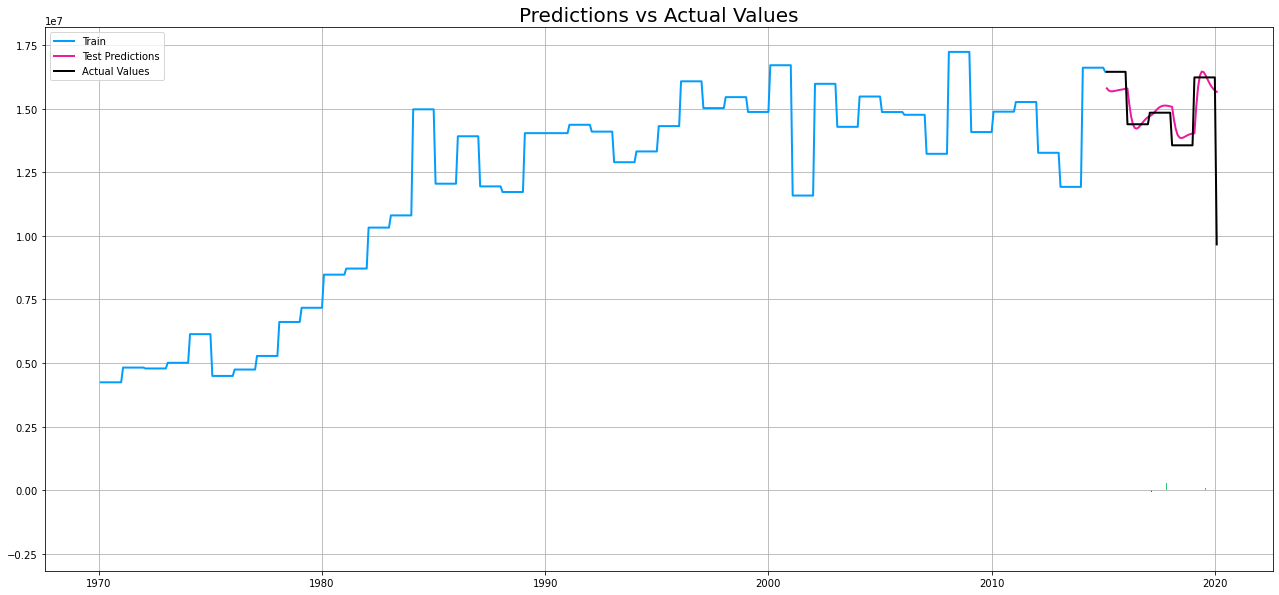

In [21]:
# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train.index; yt = train[["Production Value"]]
xv = valid.index; yv = valid[["Production Value", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
#plt.ylabel(, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Production Value"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid.index
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

# Food Consumption Analysis & Modelling using time series based LSTM model

Reading the dataset of food consumption

In [22]:
data_consump = pd.read_csv("C:/Users/Sharoz/Downloads/UOB Subjects/Semester2/GroupProject/food_consumption.csv")

In [23]:
array = ['Wheat'] #filtering out only the wheat data
df_new = data_consump.loc[data_consump['Item'].isin(array)]

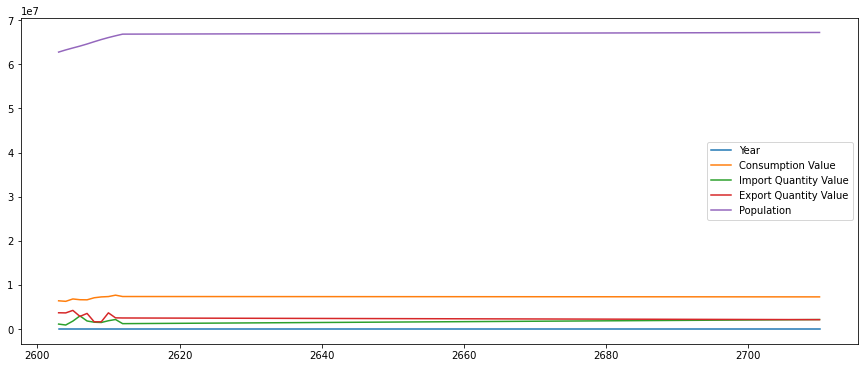

In [24]:
df_new.plot(figsize=(15,6))
df_consumption = df_new.drop(['Element','Item','Unit'],axis=1) #dropping off the unnecessary columns

In [25]:
df_consumption

,Year,Consumption Value,Import Quantity Value,Export Quantity Value,Population
2603,2010,6389000.0,1110861.0,3674553.0,62766365.0
2604,2011,6268000.0,901511.0,3645254.0,63258810.0
2605,2012,6807000.0,1784946.0,4213126.0,63700215.0
2606,2013,6632000.0,2963404.0,2853089.0,64128273.0
2607,2014,6610000.0,1815285.0,3526823.0,64602298.0
2608,2015,7075000.0,1537799.0,1626114.0,65116219.0
2609,2016,7270000.0,1472283.0,1624012.0,65611593.0
2610,2017,7347000.0,1868861.0,3657581.0,66058859.0
2611,2018,7667000.0,2148066.0,2523344.0,66460344.0
2612,2019,7359000.0,1210184.0,2494775.0,66836327.0


# Resampling of yearly data into monthly to get the sufficient data points

In [26]:
datetime_series = pd.to_datetime(df_consumption['Year'].astype(str))
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df_consumption.set_index(datetime_index)
df.drop('Year',axis=1,inplace=True)
df

,Consumption Value,Import Quantity Value,Export Quantity Value,Population
2010-01-01,6389000.0,1110861.0,3674553.0,62766365.0
2011-01-01,6268000.0,901511.0,3645254.0,63258810.0
2012-01-01,6807000.0,1784946.0,4213126.0,63700215.0
2013-01-01,6632000.0,2963404.0,2853089.0,64128273.0
2014-01-01,6610000.0,1815285.0,3526823.0,64602298.0
2015-01-01,7075000.0,1537799.0,1626114.0,65116219.0
2016-01-01,7270000.0,1472283.0,1624012.0,65611593.0
2017-01-01,7347000.0,1868861.0,3657581.0,66058859.0
2018-01-01,7667000.0,2148066.0,2523344.0,66460344.0
2019-01-01,7359000.0,1210184.0,2494775.0,66836327.0


In [27]:
df_consump_monthly = df.resample('M').ffill()
df_consump_monthly

,Consumption Value,Import Quantity Value,Export Quantity Value,Population
2010-01-31,6389000.0,1110861.0,3674553.0,62766365.0
2010-02-28,6389000.0,1110861.0,3674553.0,62766365.0
2010-03-31,6389000.0,1110861.0,3674553.0,62766365.0
2010-04-30,6389000.0,1110861.0,3674553.0,62766365.0
2010-05-31,6389000.0,1110861.0,3674553.0,62766365.0
...,...,...,...,...
2019-09-30,7359000.0,1210184.0,2494775.0,66836327.0
2019-10-31,7359000.0,1210184.0,2494775.0,66836327.0
2019-11-30,7359000.0,1210184.0,2494775.0,66836327.0
2019-12-31,7359000.0,1210184.0,2494775.0,66836327.0


In [28]:
train_df = df_consump_monthly.sort_index(ascending=True) #sorting the dataset based on year

# Add a dummy column to our record called “Predictions,” which will help later when it need to reverse the scaling of our data.

In [29]:
# List of considered Features
FEATURES = ['Consumption Value', 'Export Quantity Value','Import Quantity Value', 'Population' #, 'Month','Day'
            #, 'Month', 'Year', 'Adj Close','Year', 
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Consumption Value']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Consumption Value', 'Export Quantity Value', 'Import Quantity Value', 'Population']


,Consumption Value,Export Quantity Value,Import Quantity Value,Population,Prediction
2019-09-30,7359000.0,2494775.0,1210184.0,66836327.0,7359000.0
2019-10-31,7359000.0,2494775.0,1210184.0,66836327.0,7359000.0
2019-11-30,7359000.0,2494775.0,1210184.0,66836327.0,7359000.0
2019-12-31,7359000.0,2494775.0,1210184.0,66836327.0,7359000.0
2020-01-31,7278000.0,2116509.0,2133002.0,67215293.0,7278000.0


In [30]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Consumption Value'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(121, 4)


In [31]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 75

# Prediction Index
index_Close = data.columns.get_loc("Consumption Value")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(34, 75, 4) (34,)
(12, 75, 4) (12,)
0.7162258756254474
0.7162258756254474


# LSTM Modelling

In [32]:
# Train the Multivariate Prediction Model

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

epochs = 30
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

300 75 4
Epoch 1/30
2/2 [==============================] - 7s 2s/step - loss: 0.4412 - val_loss: 0.0144
Epoch 2/30
2/2 [==============================] - 1s 342ms/step - loss: 0.0146 - val_loss: 0.0014
Epoch 3/30
2/2 [==============================] - 1s 337ms/step - loss: 0.0231 - val_loss: 0.0748
Epoch 4/30
2/2 [==============================] - 1s 334ms/step - loss: 0.0153 - val_loss: 0.1063
Epoch 5/30
2/2 [==============================] - 1s 337ms/step - loss: 0.0266 - val_loss: 0.0254
Epoch 6/30
2/2 [==============================] - 1s 345ms/step - loss: 0.0064 - val_loss: 0.0039
Epoch 7/30
2/2 [==============================] - 1s 350ms/step - loss: 0.0122 - val_loss: 0.0082
Epoch 8/30
2/2 [==============================] - 1s 340ms/step - loss: 0.0080 - val_loss: 0.0345
Epoch 9/30
2/2 [==============================] - 1s 353ms/step - loss: 0.0069 - val_loss: 0.0528
Epoch 10/30
2/2 [==============================] - 1s 332ms/step - loss: 0.0106 - val_loss: 0.0293
Epoch 11/30
2

# Loss Curve

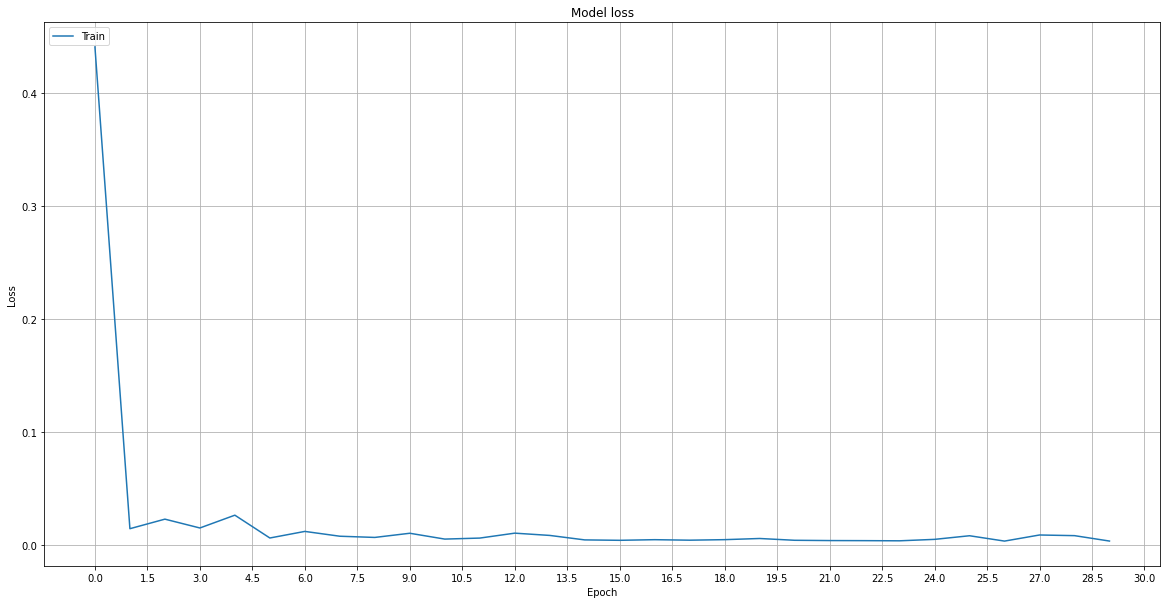

In [33]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Performance Metric - MAPE(mean absolute percentage error)

In [34]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 4.62 %


In [35]:
# Add the date column
data_filtered_sub = data_filtered.copy()
#data_filtered_sub['Year'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Consumption Value"], True)

# Line Plot of Actual Value Vs Predicted Value

C:\Users\Sharoz\anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Sharoz\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Sharoz\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

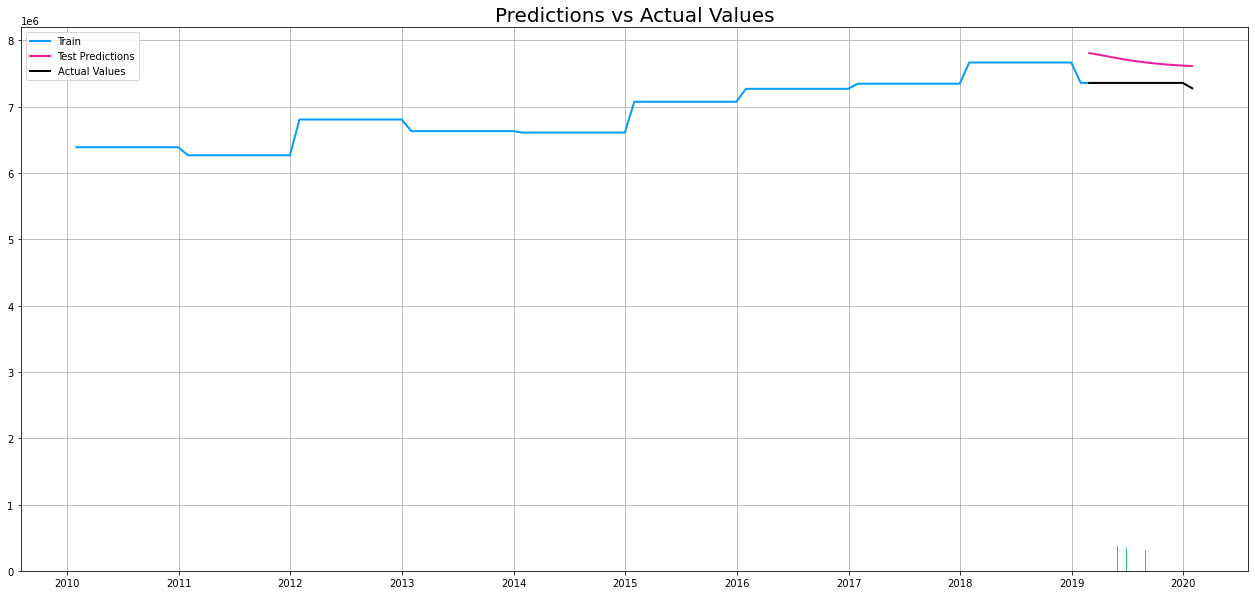

In [36]:
# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train.index; yt = train[["Consumption Value"]]
xv = valid.index; yv = valid[["Consumption Value", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
#plt.ylabel(, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Consumption Value"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid.index
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()